In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np

set_seed(1234)

2023-07-03 13:21:00.991618: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-03 13:21:01.020064: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 13:21:01.419274: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset
Create and load dataset. Split dataset into train-validation-test with 0.8, 0.1, 0.1 percentages

In [2]:
dataset_name = DatasetName.RADIOML_2016
dataset_path = os.path.abspath(cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl")
radioml_ds = make_sigmod_ds(dataset_name)
radioml_ds.load(dataset_path)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)

# Create Model
Create convolutional model

In [3]:
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName

cnn_v1_configuration = Convolution01xConfiguration(
    input_shape=(128, 2),
    n_classes=len(radioml_ds.get_modulations()),
    output_channels=[32, 48, 64, 96, 128, 192],
    kernel_sizes=[8, 8, 8, 8, 8, 8],
    paddings=["same", "same", "same", "same", "same", "same"],
    max_pool_sizes=[1, 1, 2, 1, 2, 1],
    max_pool_strides=[1, 1, 2, 1, 2, 1],
    avg_size=32,
    dense_sizes=[],
)

model = make_sigmod_model(ModelName.CNN_1D_V012, cnn_v1_configuration)

# model.summary()

2023-07-03 13:21:03.710008: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 13:21:03.724720: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-03 13:21:03.724853: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Train model
Train model with Adam optimizer + lr decay + SparseCategoricalCrossentropy loss

In [4]:
import tensorflow as tf

def step_decay(epoch):
    lrate = 0.001
    factor = epoch // 8
    lrate /= 10**factor
    return lrate


lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

N_EPOCHS = 4
BATCH_SIZE = 256

h = model.fit(
    splitted_radioml_ds.train.data,
    splitted_radioml_ds.train.labels,
    epochs=N_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
    callbacks=[lrate]
)


Epoch 1/4


2023-07-03 13:21:05.757801: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-03 13:21:06.685520: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-03 13:21:06.687828: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1fa0060fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-03 13:21:06.687847: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti Laptop GPU, Compute Capability 8.6
2023-07-03 13:21:06.691075: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-03 13:21:06.775808: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lif

688/688 [==============================] - 13s 13ms/step - loss: 1.7829 - accuracy: 0.3347 - val_loss: 1.5641 - val_accuracy: 0.4245 - lr: 0.0010
Epoch 2/4
688/688 [==============================] - 8s 11ms/step - loss: 1.4787 - accuracy: 0.4466 - val_loss: 1.3934 - val_accuracy: 0.4723 - lr: 0.0010
Epoch 3/4
688/688 [==============================] - 8s 11ms/step - loss: 1.3081 - accuracy: 0.5022 - val_loss: 1.2578 - val_accuracy: 0.5232 - lr: 0.0010
Epoch 4/4
688/688 [==============================] - 8s 11ms/step - loss: 1.2274 - accuracy: 0.5360 - val_loss: 1.2348 - val_accuracy: 0.5385 - lr: 0.0010


# Evaluation
Check train plots, confusion matrices, snr to accuracy

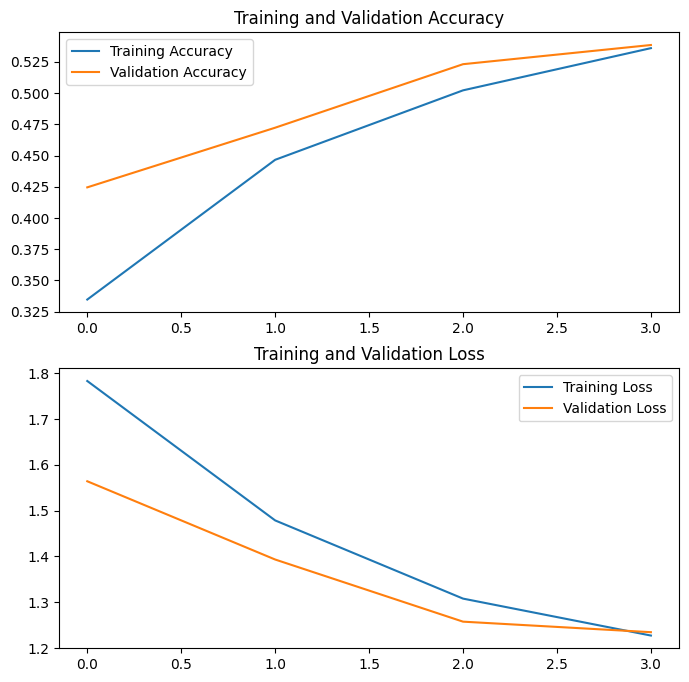

In [5]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_train, plot_snr_to_acc
plot_train(h.history)

Overall test accuracy: {'Overall': 0.5359090909090909}
8PSK test accuracy: 0.34527518172377986
AM-DSB test accuracy: 0.6417910447761194
AM-SSB test accuracy: 0.9650145772594753
BPSK test accuracy: 0.6018251681075889
CPFSK test accuracy: 0.5913088463528194
GFSK test accuracy: 0.6230807330361565
PAM4 test accuracy: 0.6489630753667173
QAM16 test accuracy: 0.08637044433349975
QAM64 test accuracy: 0.6633216256899147
QPSK test accuracy: 0.5366478728856996
WBFM test accuracy: 0.1806640625
Confusion matrix:
[[ 665    3  650   46   30   32   10   55   54  381    0]
 [   1 1290  604    3    1   48    0    4    0    2   57]
 [   3    4 1986   17    8   28    4    4    0    4    0]
 [  18    2  678 1253    5   18   73   13    1   19    2]
 [  22    3  637   21 1143   34    5   27   14   25    2]
 [   6   44  620   15   18 1258    2    3    0    6   47]
 [  16    3  522  101    7   12 1283   17    1   14    1]
 [  90    3  407   47   18   21   24  173 1135   84    1]
 [  50    3  287   44   23    6

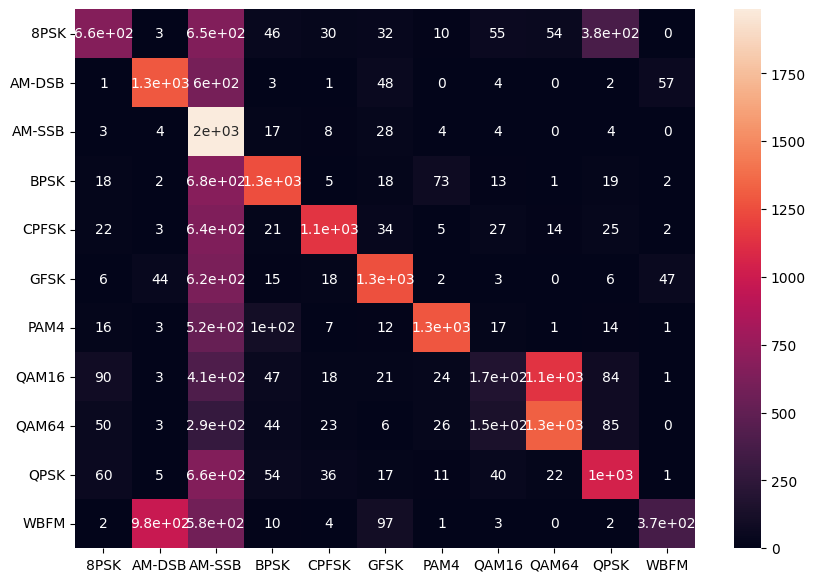

Overall test accuracy: {'Overall': 0.5385454545454545}
8PSK test accuracy: 0.3634928984744871
AM-DSB test accuracy: 0.6481294236602629
AM-SSB test accuracy: 0.9606656580937972
BPSK test accuracy: 0.6069979716024341
CPFSK test accuracy: 0.597478176527643
GFSK test accuracy: 0.6212121212121212
PAM4 test accuracy: 0.6682855755220981
QAM16 test accuracy: 0.07707910750507099
QAM64 test accuracy: 0.6573896353166987
QPSK test accuracy: 0.533099297893681
WBFM test accuracy: 0.17369727047146402
Confusion matrix:
[[ 691    3  660   43   21   16    5   66   43  353    0]
 [   2 1282  580    7    7   39    0    1    0    0   60]
 [  14    3 1905   23    6   15    4    5    0    6    2]
 [  20    5  640 1197    7   20   58    9    3   11    2]
 [  22    6  687   14 1232   39    2   31    7   21    1]
 [   1   33  613    6   24 1230    1    4    0    5   63]
 [  12    5  497  113    5   14 1376   15    6   15    1]
 [  91    4  454   49   19   14   14  152 1104   71    0]
 [  75    1  300   41   21 

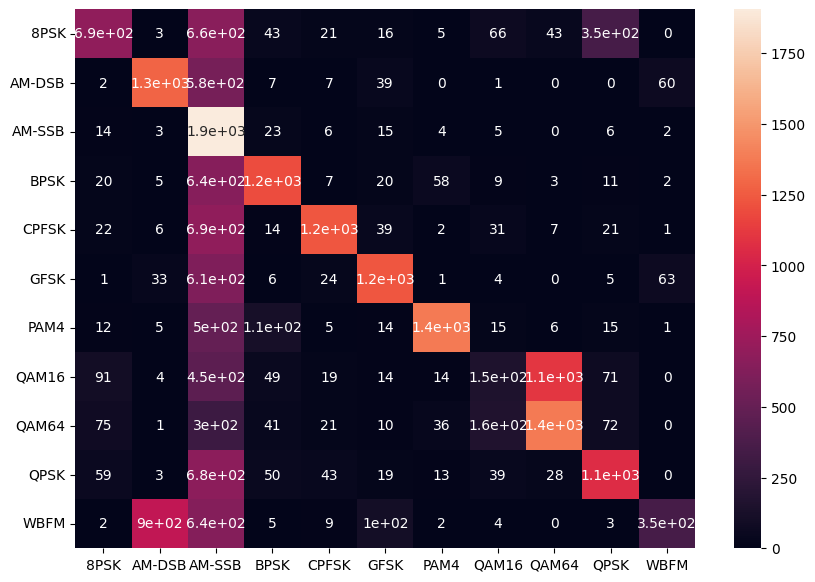

In [6]:
cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.1044776119402985
SNR: -18 -- Overall test accuracy: 0.08870967741935484
SNR: -16 -- Overall test accuracy: 0.09905660377358491
SNR: -14 -- Overall test accuracy: 0.07782805429864253
SNR: -12 -- Overall test accuracy: 0.11889400921658987
SNR: -10 -- Overall test accuracy: 0.19113573407202217
SNR: -8 -- Overall test accuracy: 0.335387323943662
SNR: -6 -- Overall test accuracy: 0.4958217270194986
SNR: -4 -- Overall test accuracy: 0.6065719360568383
SNR: -2 -- Overall test accuracy: 0.6963028169014085
SNR: 0 -- Overall test accuracy: 0.7564338235294118
SNR: 2 -- Overall test accuracy: 0.802007299270073
SNR: 4 -- Overall test accuracy: 0.7776744186046511
SNR: 6 -- Overall test accuracy: 0.8032056990204809
SNR: 8 -- Overall test accuracy: 0.7950594693504117
SNR: 10 -- Overall test accuracy: 0.8104395604395604
SNR: 12 -- Overall test accuracy: 0.8088768115942029
SNR: 14 -- Overall test accuracy: 0.7843833185448092
SNR: 16 -- Overall test accuracy: 0.778618

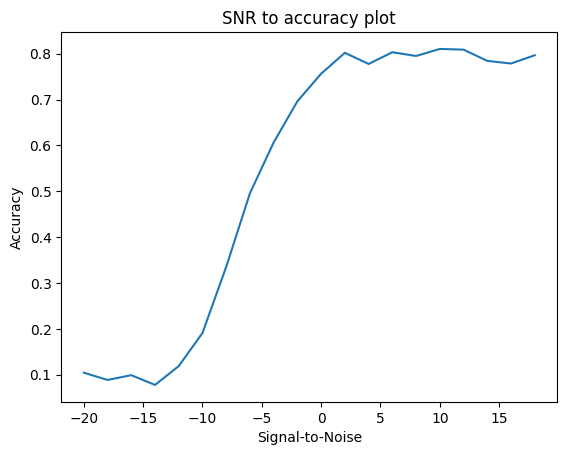

In [7]:
snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)
plot_snr_to_acc(snr_to_acc_test)

# Save results

In [8]:
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
history["lr"] = list(map(lambda x: float(x), history["lr"]))

dump_results(
    "cnn_test_results/",
    model=model,
    model_config=cnn_v1_configuration,
    model_name=ModelName.CNN_1D_V012,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=history,
    cm_test=cm_test,
    cls_to_acc_test=cls_to_acc_test,
    snr_to_acc_test=snr_to_acc_test,
    cm_val=cm_val,
    cls_to_acc_val=cls_to_acc_val,
    snr_to_acc_val=snr_to_acc_val,
    dump_model=True,
)

# TF lite
Convert model to TF lite with/without quantization, and evaluate

1. No quantization

INFO:tensorflow:Assets written to: cnn_test_results/model_original/assets


INFO:tensorflow:Assets written to: cnn_test_results/model_original/assets
2023-07-03 14:05:29.574089: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-03 14:05:29.574119: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-03 14:05:29.574281: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_test_results/model_original
2023-07-03 14:05:29.576793: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-03 14:05:29.576809: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_test_results/model_original
2023-07-03 14:05:29.584558: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-03 14:05:29.674501: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: cnn_test_results/model_original
2023-07-03 14:05:29.6

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.5359545454545455}
8PSK test accuracy: 0.34527518172377986
AM-DSB test accuracy: 0.6417910447761194
AM-SSB test accuracy: 0.9650145772594753
BPSK test accuracy: 0.6018251681075889
CPFSK test accuracy: 0.5913088463528194
GFSK test accuracy: 0.6230807330361565
PAM4 test accuracy: 0.6489630753667173
QAM16 test accuracy: 0.08686969545681478
QAM64 test accuracy: 0.6633216256899147
QPSK test accuracy: 0.5366478728856996
WBFM test accuracy: 0.1806640625
Confusion matrix:
[[ 665    3  650   46   30   32   10   55   54  381    0]
 [   1 1290  604    3    1   48    0    4    0    2   57]
 [   3    4 1986   17    8   28    4    4    0    4    0]
 [  18    2  678 1253    5   18   73   13    1   19    2]
 [  22    3  637   21 1143   34    5   27   14   25    2]
 [   6   44  620   15   18 1258    2    3    0    6   47]
 [  16    3  522  101    7   12 1283   17    1   14    1]
 [  90    3  407   47   18   21   24  174 1134   84    1]
 [  50

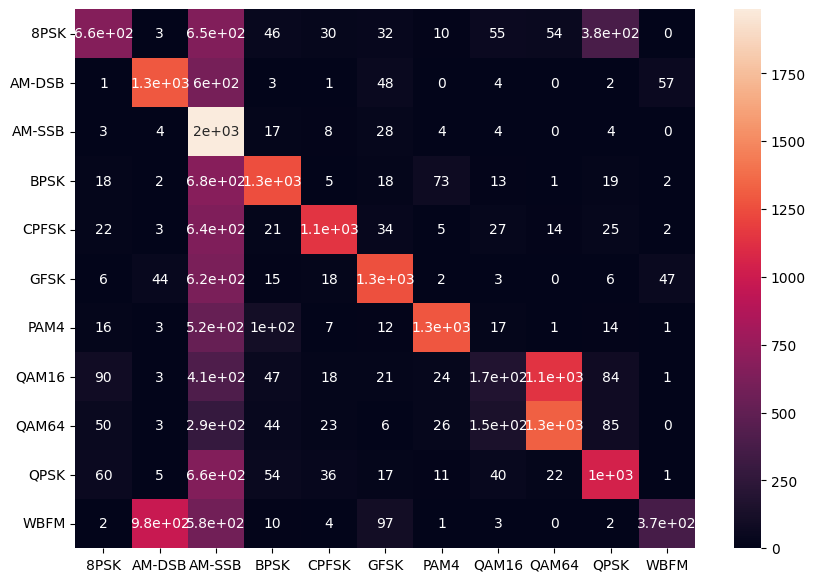

SNR: -20 -- Overall test accuracy: 0.1044776119402985
SNR: -18 -- Overall test accuracy: 0.08870967741935484
SNR: -16 -- Overall test accuracy: 0.09905660377358491
SNR: -14 -- Overall test accuracy: 0.07782805429864253
SNR: -12 -- Overall test accuracy: 0.11889400921658987
SNR: -10 -- Overall test accuracy: 0.19113573407202217
SNR: -8 -- Overall test accuracy: 0.335387323943662
SNR: -6 -- Overall test accuracy: 0.4958217270194986
SNR: -4 -- Overall test accuracy: 0.6065719360568383
SNR: -2 -- Overall test accuracy: 0.6963028169014085
SNR: 0 -- Overall test accuracy: 0.7564338235294118
SNR: 2 -- Overall test accuracy: 0.802007299270073
SNR: 4 -- Overall test accuracy: 0.7776744186046511
SNR: 6 -- Overall test accuracy: 0.8032056990204809
SNR: 8 -- Overall test accuracy: 0.7950594693504117
SNR: 10 -- Overall test accuracy: 0.8113553113553114
SNR: 12 -- Overall test accuracy: 0.8088768115942029
SNR: 14 -- Overall test accuracy: 0.7843833185448092
SNR: 16 -- Overall test accuracy: 0.778618

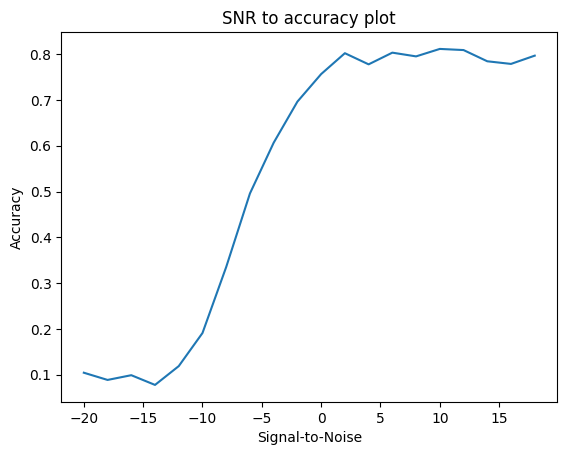

In [17]:
reload_module("deployment_tools")
reload_module("evaluation.metric_evaluation")
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

model_path = "cnn_test_results/model_original"
model.save(model_path)

model_tflile_no_quant = to_tf_lite(model_path, apply_quantization=False)

cm_test_tflite_no_quant, cls_to_acc_test_tflite_no_quant = metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite_no_quant = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite_no_quant)

2023-07-03 14:09:22.710473: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-07-03 14:09:22.710496: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-07-03 14:09:22.710640: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_test_results/model_original
2023-07-03 14:09:22.712732: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-07-03 14:09:22.712746: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_test_results/model_original
2023-07-03 14:09:22.719187: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-07-03 14:09:22.792666: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: cnn_test_results/model_original
2023-07-03 14:09:22.810128: I tensorflow/cc/saved_model/loader.cc:314] SavedModel load for tags

Preds shape: (22000, 11)
Overall test accuracy: {'Overall': 0.5359545454545455}
8PSK test accuracy: 0.34527518172377986
AM-DSB test accuracy: 0.6417910447761194
AM-SSB test accuracy: 0.9650145772594753
BPSK test accuracy: 0.6018251681075889
CPFSK test accuracy: 0.5913088463528194
GFSK test accuracy: 0.6230807330361565
PAM4 test accuracy: 0.6489630753667173
QAM16 test accuracy: 0.08686969545681478
QAM64 test accuracy: 0.6633216256899147
QPSK test accuracy: 0.5366478728856996
WBFM test accuracy: 0.1806640625
Confusion matrix:
[[ 665    3  650   46   30   32   10   55   54  381    0]
 [   1 1290  604    3    1   48    0    4    0    2   57]
 [   3    4 1986   17    8   28    4    4    0    4    0]
 [  18    2  678 1253    5   18   73   13    1   19    2]
 [  22    3  637   21 1143   34    5   27   14   25    2]
 [   6   44  620   15   18 1258    2    3    0    6   47]
 [  16    3  522  101    7   12 1283   17    1   14    1]
 [  90    3  407   47   18   21   24  174 1134   84    1]
 [  50

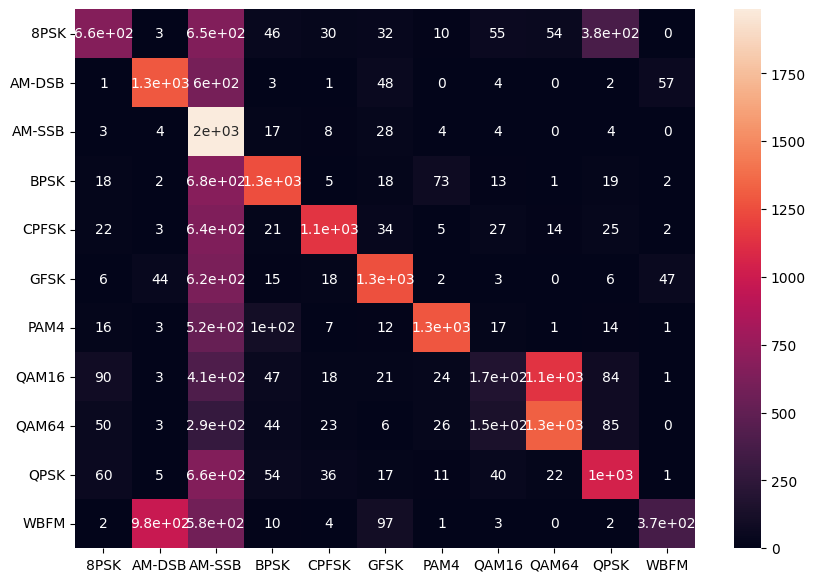

SNR: -20 -- Overall test accuracy: 0.1044776119402985
SNR: -18 -- Overall test accuracy: 0.08870967741935484
SNR: -16 -- Overall test accuracy: 0.09905660377358491
SNR: -14 -- Overall test accuracy: 0.07782805429864253
SNR: -12 -- Overall test accuracy: 0.11889400921658987
SNR: -10 -- Overall test accuracy: 0.19113573407202217
SNR: -8 -- Overall test accuracy: 0.335387323943662
SNR: -6 -- Overall test accuracy: 0.4958217270194986
SNR: -4 -- Overall test accuracy: 0.6065719360568383
SNR: -2 -- Overall test accuracy: 0.6963028169014085
SNR: 0 -- Overall test accuracy: 0.7564338235294118
SNR: 2 -- Overall test accuracy: 0.802007299270073
SNR: 4 -- Overall test accuracy: 0.7776744186046511
SNR: 6 -- Overall test accuracy: 0.8032056990204809
SNR: 8 -- Overall test accuracy: 0.7950594693504117
SNR: 10 -- Overall test accuracy: 0.8113553113553114
SNR: 12 -- Overall test accuracy: 0.8088768115942029
SNR: 14 -- Overall test accuracy: 0.7843833185448092
SNR: 16 -- Overall test accuracy: 0.778618

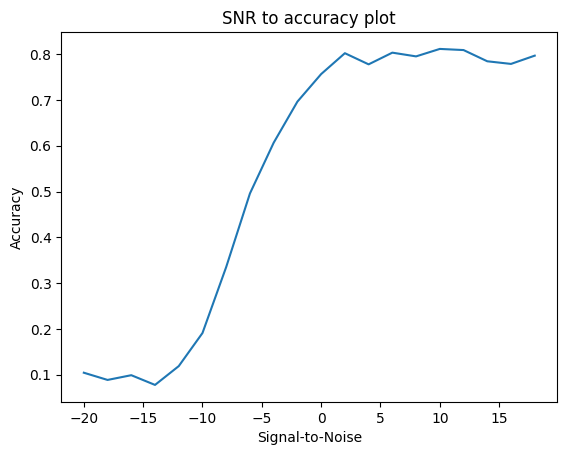

In [19]:
representative_ds = splitted_radioml_ds.train.data[:4000].astype(np.float32)
model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_tflite = snr_to_metric_evaluation(
    model_tflile_no_quant,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_tflite)